In [106]:
# import tensorflow as tf
# import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
# import xgboost as xgb
import time
import datetime
# from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
# from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [4]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [5]:
np.asarray(players.loc[(players['last_name'] == 'Fritz') & (players['first_name'] == 'Taylor Harry')]['player_id'])[0]
# players.loc[(players['last_name'] == 'Fritz')]

126203

In [131]:
#read all CSVs here and concatenate to form one dataframe
# df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

#enter years form which to take data: [start, end]
years = [2014, 2019]
df = pd.DataFrame()

for year in np.arange(years[0], years[1]+1):
    df_year = pd.read_csv(f'/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_{year}.csv')
    df = pd.concat([df,df_year])

In [132]:
df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2014-339,Brisbane,Hard,28,A,20131229,1,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,32.438056,105902,NaN,WC,James Duckworth,R,183.0,AUS,21.941136,6-2 6-3,3,R32,72.0,5.0,3.0,71.0,54.0,36.0,9.0,9.0,5.0,5.0,9.0,7.0,51.0,29.0,23.0,6.0,8.0,2.0,5.0,39.0,1090.0,136.0,425.0
1,2014-339,Brisbane,Hard,28,A,20131229,2,104594,NaN,NaN,Marinko Matosevic,R,194.0,AUS,28.394251,103898,NaN,NaN,Julien Benneteau,R,185.0,FRA,32.027379,5-7 6-4 7-6(4),3,R32,161.0,11.0,3.0,112.0,68.0,43.0,26.0,17.0,5.0,9.0,14.0,1.0,117.0,76.0,51.0,18.0,17.0,7.0,11.0,61.0,774.0,35.0,1160.0
2,2014-339,Brisbane,Hard,28,A,20131229,3,105023,NaN,NaN,Sam Querrey,R,198.0,USA,26.231348,104098,7,NaN,Dmitry Tursunov,R,185.0,RUS,31.049966,7-5 6-4,3,R32,77.0,18.0,1.0,58.0,40.0,36.0,7.0,11.0,2.0,3.0,4.0,0.0,63.0,40.0,26.0,12.0,11.0,6.0,9.0,46.0,960.0,29.0,1244.0
3,2014-339,Brisbane,Hard,28,A,20131229,4,105032,NaN,WC,Sam Groth,R,NaN,AUS,26.198494,105992,NaN,Q,Ryan Harrison,R,183.0,USA,21.648186,7-6(3) 7-6(2),3,R32,95.0,23.0,2.0,70.0,51.0,46.0,10.0,12.0,1.0,1.0,5.0,4.0,86.0,59.0,43.0,15.0,12.0,4.0,4.0,172.0,307.0,100.0,549.0
4,2014-339,Brisbane,Hard,28,A,20131229,5,103917,NaN,NaN,Nicolas Mahut,R,190.0,FRA,31.939767,104997,NaN,NaN,Igor Sijsling,R,190.0,NED,26.368241,3-6 6-4 6-4,3,R32,107.0,15.0,4.0,100.0,59.0,46.0,18.0,15.0,4.0,6.0,13.0,2.0,78.0,50.0,43.0,12.0,14.0,2.0,4.0,50.0,918.0,70.0,697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,2019-M-DC-2019-QLS-M-SUI-RUS-01,Davis Cup QLS R1: SUI vs RUS,Hard,4,D,20190201,2,111575,NaN,NaN,Karen Khachanov,R,NaN,RUS,22.688569,144817,NaN,NaN,Marc Andrea Huesler,U,NaN,SUI,22.595483,6-3 7-5,3,RR,76.0,7.0,1.0,50.0,38.0,31.0,10.0,11.0,0.0,0.0,7.0,2.0,78.0,47.0,32.0,14.0,10.0,5.0,8.0,11.0,2880.0,362.0,56.0
2777,2019-M-DC-2019-QLS-M-SUI-RUS-01,Davis Cup QLS R1: SUI vs RUS,Hard,4,D,20190201,4,111575,NaN,NaN,Karen Khachanov,R,NaN,RUS,22.688569,105967,NaN,NaN,Henri Laaksonen,R,NaN,SUI,26.828200,6-7(2) 7-6(6) 6-4,3,RR,161.0,13.0,3.0,112.0,75.0,54.0,24.0,17.0,3.0,4.0,13.0,5.0,145.0,94.0,65.0,27.0,17.0,15.0,17.0,11.0,2880.0,142.0,389.0
2778,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,1,105053,NaN,NaN,Santiago Giraldo,R,188.0,COL,31.170431,111200,NaN,NaN,Elias Ymer,R,NaN,SWE,22.800821,6-2 6-4,3,RR,72.0,5.0,5.0,62.0,40.0,31.0,9.0,9.0,2.0,3.0,3.0,3.0,49.0,33.0,20.0,7.0,9.0,1.0,5.0,251.0,190.0,116.0,485.0
2779,2019-M-DC-2019-QLS-M-SWE-COL-01,Davis Cup QLS R1: SWE vs COL,Clay,4,D,20190201,2,123755,NaN,NaN,Daniel Elahi Galan,U,NaN,COL,22.611910,144707,NaN,NaN,Mikael Ymer,R,NaN,SWE,20.386037,6-1 6-2,3,RR,74.0,7.0,0.0,53.0,31.0,26.0,10.0,8.0,2.0,2.0,1.0,4.0,49.0,31.0,14.0,9.0,7.0,2.0,6.0,228.0,224.0,194.0,267.0


In [133]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [134]:
#unique ids in the csv
ids = pd.concat([df['winner_id'], df['loser_id']]).unique()
ids

array([103813, 104594, 105023, 105032, 103917, 104871, 103852, 103720,
       105657, 105777, 105227, 105051, 103819, 105453, 103794, 105379,
       104628, 106026, 104229, 105577, 104719, 106368, 104198, 104273,
       106210, 104534, 104527, 105332, 104745, 104735, 103997, 105208,
       103333, 104460, 105376, 104259, 104269, 103812, 104252, 104918,
       104755, 104792, 104978, 103970, 105385, 105053, 105449, 105614,
       104547, 105041, 105138, 106058, 104545, 103285, 105077, 104586,
       104797, 103898, 104660, 106071, 104882, 105238, 105223, 104098,
       106423, 104312, 105583, 105683, 106401, 104672, 103582, 103565,
       104308, 105641, 105373, 104542, 105064, 104468, 104559, 104607,
       104932, 106000, 104471, 104731, 106233, 104022, 104665, 105668,
       105173, 104268, 103990, 103786, 104926, 104919, 104925, 105842,
       105585, 105497, 103607, 144773, 124063, 104673, 105877, 106175,
       104500, 105031, 105311, 106393, 105413, 105011, 106174, 105985,
      

In [135]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
for target_pid in tqdm_notebook(ids):
# for target_pid in ids:
    ### get features from whether the target player won or lost
    df2 = df[(df.loc[:,'winner_id'] == target_pid ) | (df.loc[:,'loser_id'] == target_pid)]

    ###create target column here
    y = [1 if pid==target_pid else 0 for pid in df2.winner_id.values]
    y = pd.DataFrame(data=y, columns=['target'])

    ###switch up the dataframe to account for losses since after 
    ###taking target into account, we dont care about winner/loser specific columns
#     swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
    swapped_features = ['ace', 'df', 'bpSaved', 'bpFaced']
    for swapFeat in swapped_features:
        df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

    ### sort by tournament date and match number so features are sequential/time-dependant
    df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

    ###extract stats from features
    segments = df2.shape[0]
#     features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
    features = ['w_ace', 'w_df', 'w_bpSaved', 'w_bpFaced']
    x_tr = extract_stats(df2, segments, features)

    df2.reset_index(drop=True, inplace=True)
    x_tr.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    x_tr = pd.concat([df2['tourney_date'], df2['match_num'], y['target'], x_tr], axis=1)

    # ### save to dictionary by PID
    pid_dict.update({f'{target_pid}' : x_tr})

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdi

In [137]:
len(pid_dict)

897

In [192]:
#tournament date cutoff for validation data
val_tourney_date = 20191001

#number of rows before/equal to cutoff date
rows = (df['tourney_date'] < val_tourney_date).value_counts()
train_rows = rows[1]
val_rows = rows[0]

print(f"training samples: {train_rows}")
print(f"val samples: {val_rows}")

#number of statistical measures taken across features
num_stats = x_tr.shape[1]-3
print(num_stats)

### iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_train = np.empty(shape=(int(train_rows*2), num_stats))
y_train = np.empty(shape=(int(train_rows*2), 1))

x_val = np.empty(shape=(int(val_rows*2), num_stats))
y_val = np.empty(shape=(int(val_rows*2), 1))

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

#initialize counters
j = 0
k = 0

for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):
# for winner_id, loser_id, tdate, match_num in zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values):    
    
    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])[:1,:]

    #add to train or validation set based on cutoff date chosen
    if tdate < val_tourney_date:
        ### add to x_train array
        #diff the features from winner to loser and count as a win
        x_train[j,:] = features_w - features_l
        y_train[j,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_train[j+1,:] = features_l - features_w
        y_train[j+1,0] = 0.0
        
        #increment counter
        j+=2
    else:
        ### add to x_val array
        x_val[k,:] = features_w - features_l
        y_val[k,0] = 1.0

        #diff the features from loser to winner and count as a loss
        x_val[k+1,:] = features_l - features_w
        y_val[k+1,0] = 0.0
        
        #increment counter
        k+=2

training samples: 17031
val samples: 310
230


# LGBM developement

### Random searh for hyperparameter optimization

In [193]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(15, 150), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_val, y_val[:,0])],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [194]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

clf = lgb.LGBMClassifier(max_depth=-1, 
                         random_state=7, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=5000)

gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=7,
                        verbose=True)

In [195]:
gs.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.776358
[200]	valid's auc: 0.787003
Early stopping, best iteration is:
[218]	valid's auc: 0.787888
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.774693
Early stopping, best iteration is:
[128]	valid's auc: 0.779865
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.758647
[200]	valid's auc: 0.769875
[300]	valid's auc: 0.773829
Early stopping, best iteration is:
[302]	valid's auc: 0.774017
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.750219
[200]	valid's auc: 0.758429
[300]	valid's auc: 0.763996
[400]	valid's auc: 0.767232
[500]	valid's auc: 0.771363
[600]	valid's auc: 0.773361
Early stopping, best iteration is:
[593]	valid's auc: 0.773704
Training until validation scores don't improve for 30 rounds
[100]	valid's auc: 0.75128
[200]	valid's auc: 0.757367
[300]	valid's auc: 0.760822
[400]	valid's auc: 0.764

KeyboardInterrupt: 

### Train with optimal params

In [ ]:
# using LGBM lib here
# link to original work: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [205]:
# params = {'num_leaves': 128,
#           'min_data_in_leaf': 79,
#           'max_depth': -1,
#           'learning_rate': 0.01,
#           "boosting": "gbdt",
#           "bagging_freq": 5,
#           "bagging_fraction": 0.8126672064208567,
#           "bagging_seed": 11,
#           "verbosity": -1,
#           'reg_alpha': 0.1302650970728192,
#           'reg_lambda': 0.3603427518866501}

params = {'colsample_bytree': 0.4547750739937686, 
          'min_child_samples': 477,
          'min_child_weight': 1e-05,
          'min_data_in_leaf': 69,
          'num_leaves': 127,
          'reg_alpha': 10,
          'reg_lambda': 50,
          'subsample': 0.3888893334252399,
          'boosting': "gbdt"} 

model = lgb.LGBMClassifier(**params,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary')

model.fit(x_train, y_train[:,0],
          eval_set=[(x_train, y_train[:,0]), (x_val, y_val[:,0])],
          verbose=True,
          early_stopping_rounds=50)

[1]	valid_0's binary_logloss: 0.678017	valid_1's binary_logloss: 0.680422
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.666256	valid_1's binary_logloss: 0.671647
[3]	valid_0's binary_logloss: 0.654611	valid_1's binary_logloss: 0.662146
[4]	valid_0's binary_logloss: 0.645362	valid_1's binary_logloss: 0.655093
[5]	valid_0's binary_logloss: 0.637221	valid_1's binary_logloss: 0.648414
[6]	valid_0's binary_logloss: 0.629207	valid_1's binary_logloss: 0.641577
[7]	valid_0's binary_logloss: 0.622077	valid_1's binary_logloss: 0.636152
[8]	valid_0's binary_logloss: 0.615691	valid_1's binary_logloss: 0.631159
[9]	valid_0's binary_logloss: 0.609275	valid_1's binary_logloss: 0.626152
[10]	valid_0's binary_logloss: 0.603279	valid_1's binary_logloss: 0.622237
[11]	valid_0's binary_logloss: 0.598189	valid_1's binary_logloss: 0.619077
[12]	valid_0's binary_logloss: 0.592592	valid_1's binary_logloss: 0.616936
[13]	valid_0's binary_logloss: 0.588588	valid_1'

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4547750739937686, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=477,
               min_child_weight=1e-05, min_data_in_leaf=69, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=127, objective='binary',
               random_state=None, reg_alpha=10, reg_lambda=50, silent=True,
               subsample=0.3888893334252399, subsample_for_bin=200000,
               subsample_freq=0)

In [208]:
y_pred = model.predict(x_val)

In [209]:
print(accuracy_score(y_val, y_pred))

0.7129032258064516


# Evaluation

#### ROC Curve to determine threshold

In [210]:
from sklearn.metrics import roc_auc_score

In [211]:
y_pred = model.predict_proba(x_val)[:,1]

0.6631784231639305


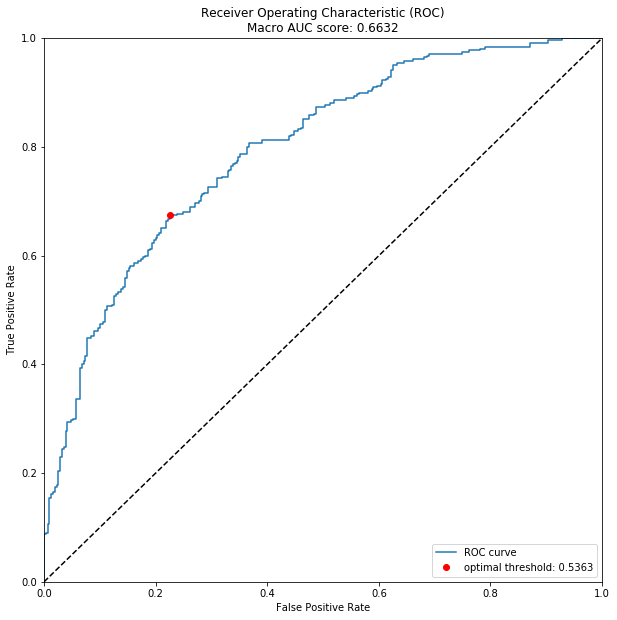

In [212]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
mac_roc_auc = roc_auc_score(y_val, y_pred, average='macro')
mic_roc_auc = roc_auc_score(y_val, y_pred, average='micro')
print(roc_auc)

#optimal threshold from ROC curve
#minimum euclid distance between (0,1) threshold points
min_arg = np.argmin(euclid_distance(fpr, tpr, opt_point=(0,1)))
opt_thres = thresholds[min_arg]

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.plot(fpr[min_arg], tpr[min_arg], 'ro', label=f'optimal threshold: {opt_thres:0.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC)\nMacro AUC score: {roc_auc:0.4f}')
plt.legend(loc="lower right")

#### Feature importance

In [149]:
#get feature columns
fcols = pid_dict['100644'].loc[:, 'ace_mean':].columns

In [150]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = fcols
fold_importance["importance"] = model.feature_importances_
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

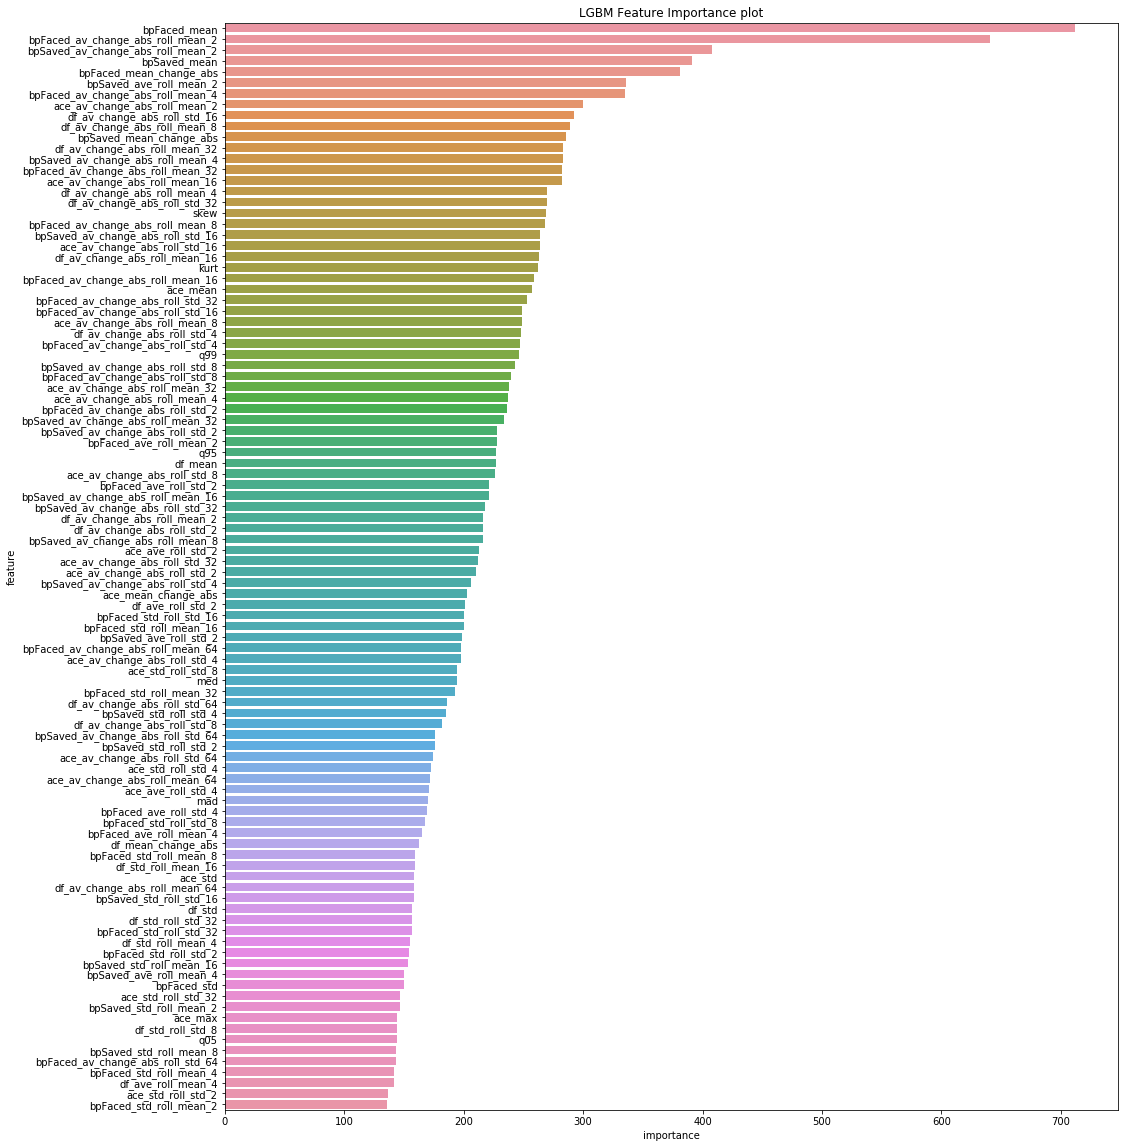

In [152]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

In [153]:
#get indices of top n columns (im choosing 50 here)
top_cols = np.argsort(-model.feature_importances_)[:50]

In [154]:
# Taking less columns seriously decreases score.
x_train_trim = x_train[:,top_cols]
x_val_trim = x_val[:,top_cols]

params = {'colsample_bytree': 0.4547750739937686, 
          'min_child_samples': 477,
          'min_child_weight': 1e-05,
          'min_data_in_leaf': 69,
          'num_leaves': 127,
          'reg_alpha': 10,
          'reg_lambda': 50,
          'subsample': 0.3888893334252399,
          'boosting': "gbdt"} 

model = lgb.LGBMClassifier(**params,
                           n_estimators = 3000,
                           n_jobs = 6, 
                           objective='binary')

model.fit(x_train_trim, y_train[:,0],
          eval_set=[(x_train_trim, y_train[:,0]), (x_val_trim, y_val[:,0])],
          verbose=True)

[1]	valid_0's binary_logloss: 0.68164	valid_1's binary_logloss: 0.684813
[2]	valid_0's binary_logloss: 0.67162	valid_1's binary_logloss: 0.677599
[3]	valid_0's binary_logloss: 0.66443	valid_1's binary_logloss: 0.672508
[4]	valid_0's binary_logloss: 0.654461	valid_1's binary_logloss: 0.665415
[5]	valid_0's binary_logloss: 0.647047	valid_1's binary_logloss: 0.659956
[6]	valid_0's binary_logloss: 0.639197	valid_1's binary_logloss: 0.654312
[7]	valid_0's binary_logloss: 0.631617	valid_1's binary_logloss: 0.648697
[8]	valid_0's binary_logloss: 0.626436	valid_1's binary_logloss: 0.645187
[9]	valid_0's binary_logloss: 0.621805	valid_1's binary_logloss: 0.641974
[10]	valid_0's binary_logloss: 0.616686	valid_1's binary_logloss: 0.639264
[11]	valid_0's binary_logloss: 0.612293	valid_1's binary_logloss: 0.637223
[12]	valid_0's binary_logloss: 0.608062	valid_1's binary_logloss: 0.635424
[13]	valid_0's binary_logloss: 0.604661	valid_1's binary_logloss: 0.63423
[14]	valid_0's binary_logloss: 0.60060

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.4547750739937686, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=477,
               min_child_weight=1e-05, min_data_in_leaf=69, min_split_gain=0.0,
               n_estimators=3000, n_jobs=6, num_leaves=127, objective='binary',
               random_state=None, reg_alpha=10, reg_lambda=50, silent=True,
               subsample=0.3888893334252399, subsample_for_bin=200000,
               subsample_freq=0)

In [158]:
y_pred = model.predict(x_val_trim)
# y_pred = np.expand_dims(y_pred, axis=-1)

In [159]:
print(accuracy_score(y_val, y_pred))

0.7062030530651805


## Real match prediction

In [225]:
# playerA_first_name, playerA_last_name = 'Taylor Harry', 'Fritz'
# playerB_first_name, playerB_last_name = 'John', 'Isner'

# playerA_first_name, playerA_last_name = 'Tommy', 'Paul'
# playerB_first_name, playerB_last_name = 'John', 'Isner'

playerB_first_name, playerB_last_name = 'Taylor Harry', 'Fritz'
playerA_first_name, playerA_last_name = 'John', 'Isner'

In [226]:
playerA_id = find_id(playerA_first_name, playerA_last_name)
playerB_id = find_id(playerB_first_name, playerB_last_name)

#most recent player A/B tournament date:
tdateA = np.asarray(pid_dict[f'{playerA_id}'][['tourney_date', 'match_num']])[-1][0]
tdateB = np.asarray(pid_dict[f'{playerB_id}'][['tourney_date', 'match_num']])[-1][0]

#most recent player A/B match numbers
match_numA = np.asarray(pid_dict[f'{playerA_id}'][['tourney_date', 'match_num']])[-1][1]
match_numB = np.asarray(pid_dict[f'{playerB_id}'][['tourney_date', 'match_num']])[-1][1]

#gather features from player profile dictionaries
features_a = np.asarray(pid_dict[f'{playerA_id}'].loc[(pid_dict[f'{playerA_id}']['tourney_date'] == tdateA) & (pid_dict[f'{playerA_id}']['match_num'] == match_numA)].loc[:, 'ace_mean':])
features_b = np.asarray(pid_dict[f'{playerB_id}'].loc[(pid_dict[f'{playerB_id}']['tourney_date'] == tdateB) & (pid_dict[f'{playerB_id}']['match_num'] == match_numB)].loc[:, 'ace_mean':])

#diff the features from a to b
x_dev = features_a - features_b

In [227]:
#probability that player A is going to win
y_pred_a = model.predict_proba(x_dev)

In [228]:
print(f"Probability that {playerA_first_name} {playerA_last_name} wins: {y_pred_a[0][1]*100:0.4f}%")

Probability that John Isner wins: 60.9580%


In [145]:
players.loc[(players['last_name'] == 'Isner')]
players.loc[(players['last_name'] == 'Paul')]

,player_id,first_name,last_name,hand,birthday,country_code
4650,104652,Todd,Paul,L,19851226.0,USA
7129,107144,Gregor,Paul,R,NaN,GER
8457,108472,Vijay,Paul,R,NaN,USA
9749,109764,Bernard,Paul,R,NaN,FRA
14778,114794,Vincent T,Paul,NaN,NaN,USA
25229,125245,Robert,Paul,U,19760819.0,GBR
26189,126205,Tommy,Paul,R,19970517.0,USA
39996,140012,Christian,Paul,U,19941126.0,NGR
43820,143836,Suresh,Paul,U,19730502.0,IND
52639,207605,Jakub,Paul,R,19990322.0,SUI


### Function defs

In [ ]:
def extract_stats(df, segments, features):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:
    
        #time series data
        x_full = pd.Series(df[f'{feature}'].values)
        feature_name = feature[2:]
    
        for segment in range(segments):
            #take all of x until that point in time
            x = x_full[:segment+1]
            
            #compute stats on this feature
            X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
            X_tr.loc[segment, f'{feature_name}_std'] = x.std()
            X_tr.loc[segment, f'{feature_name}_max'] = x.max()
            X_tr.loc[segment, f'{feature_name}_min'] = x.min()

            X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
            X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
            X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

            X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
            X_tr.loc[segment, 'sum'] = x.sum()

            X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
            X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
            X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
            X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)

#             X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
#             X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
#             X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
#             X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

#########################
        #     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
        #     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
        #     X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
        #     X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
#######################
            X_tr.loc[segment, 'mad'] = x.mad()
            X_tr.loc[segment, 'kurt'] = x.kurtosis()
            X_tr.loc[segment, 'skew'] = x.skew()
            X_tr.loc[segment, 'med'] = x.median()

            #rolling stats
#             for windows in [2, 4, 6, 8, 10, 12, 14, 16, 20, 25]:
            for windows in [2, 4, 8, 16, 32, 64]:
                x_roll_std = x.rolling(windows).std().dropna().values
                x_roll_mean = x.rolling(windows).mean().dropna().values

                X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])

                X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
                
    #fill all NaN values with 0
    X_tr = X_tr.fillna(value=0.0)
    
    return X_tr

In [79]:
def find_id(first_name, last_name):
    return np.asarray(players.loc[(players['last_name'] == last_name) & (players['first_name'] == first_name)]['player_id'])[0]

In [80]:
def euclid_distance(x,y, opt_point=(0,1)):
    return np.sqrt((opt_point[1] - y)**2 + (opt_point[0] - x)**2)